In [1]:
# Importing all necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.cross_validation import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error
from math import sqrt
import xgboost as xgb

%matplotlib inline
sns.set()

/home/laksh/ml/local/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/laksh/ml/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Reading the data with custom data separator ';' 
df = pd.read_csv('./dataset.csv', sep=';')

In [3]:
# Top 5 rows of the dataset
df.head()

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits
0,988681,L6,Monday,17,1,2111,31672;0,6,7037,\N
1,988680,L2,Thursday,22,10,2113,31965;0,2,49,14
2,988679,L4,Saturday,21,2,2100,0;78464,1,1892,14
3,988678,L3,Saturday,19,8,2113,51462,6,0,1
4,988677,L2,Tuesday,6,10,2116,31931;0,1,2,3


In [4]:
# Last 5 rows of the dataset
df.tail()

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits
988676,5,L2,Tuesday,18,2,2113,44232;0,2,5,\N
988677,4,L6,Tuesday,9,6,2113,38715;0;40057;31657,2,35,\N
988678,3,L2,Sunday,17,8,2114,15466;0,6,1011,\N
988679,2,L3,Monday,17,13,2113,531228;0,2,132,\N
988680,1,L4,Thursday,15,1,2116,76673;0,2,4544,18


In [5]:
# Random 5 rows of the dataset
df.sample(5)

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits
542053,446628,L4,Monday,17,10,2116,76497;0,1,10,3
804561,184120,L4,Tuesday,11,9,2113,78506;0,4,224,11
799719,188962,L3,Wednesday,7,10,2116,34759;0,4,16,5
238338,750343,L2,Wednesday,7,2,2111,31672;0,6,6,3
943273,45408,L3,Wednesday,23,9,2111,34227;0,6,32,5


By printing top and bottom rows of our dataset we can see that our dataset is in wrong order, let's fix that first!

In [6]:
# Flipping the whole dataset upside down and fixing the order
df = df.iloc[::-1].reset_index(drop=True)
df.head()

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits
0,1,L4,Thursday,15,1,2116,76673;0,2,4544,18
1,2,L3,Monday,17,13,2113,531228;0,2,132,\N
2,3,L2,Sunday,17,8,2114,15466;0,6,1011,\N
3,4,L6,Tuesday,9,6,2113,38715;0;40057;31657,2,35,\N
4,5,L2,Tuesday,18,2,2113,44232;0,2,5,\N


In [7]:
# Let's look at the numeric columns of the dataset and some of it's statistics
df.describe()

,row_num,hour_of_day,agent_id,entry_page,traffic_type
count,988681.000000,988681.000000,988681.000000,988681.000000,988681.000000
mean,494341.000000,13.203988,7.350779,2253.265114,2.773766
std,285407.765084,6.718056,3.869630,775.083390,1.920976
min,1.000000,0.000000,0.000000,2100.000000,1.000000
25%,247171.000000,8.000000,6.000000,2111.000000,1.000000
50%,494341.000000,14.000000,9.000000,2113.000000,2.000000
75%,741511.000000,19.000000,10.000000,2116.000000,4.000000
max,988681.000000,23.000000,15.000000,8101.000000,10.000000


In [8]:
# Let's look at the some info regarding the dataset such count of values in each columns and it's type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988681 entries, 0 to 988680
Data columns (total 10 columns):
row_num              988681 non-null int64
locale               988681 non-null object
day_of_week          988681 non-null object
hour_of_day          988681 non-null int64
agent_id             988681 non-null int64
entry_page           988681 non-null int64
path_id_set          983792 non-null object
traffic_type         988681 non-null int64
session_durantion    988681 non-null object
hits                 988681 non-null object
dtypes: int64(5), object(5)
memory usage: 75.4+ MB


In [9]:
df['hits'].unique()

array(['18', '\\N', '2', '37', '69', '3', '25', '33', '1', '11', '5',
       '22', '70', '6', '4', '27', '8', '12', '20', '13', '126', '7',
       '17', '56', '21', '10', '279', '28', '31', '16', '236', '40', '15',
       '14', '87', '30', '9', '45', '51', '32', '46', '42', '23', '52',
       '60', '24', '63', '39', '19', '107', '80', '76', '26', '53', '41',
       '58', '35', '44', '143', '77', '43', '57', '36', '29', '248', '61',
       '138', '148', '363', '48', '78', '47', '103', '86', '131', '50',
       '109', '132', '64', '99', '34', '95', '49', '93', '62', '67',
       '105', '120', '88', '59', '38', '114', '96', '75', '212', '135',
       '169', '89', '54', '179', '85', '92', '112', '118', '128', '375',
       '359', '55', '382', '82', '916', '111', '130', '174', '71', '98',
       '83', '73', '137', '108', '159', '81', '317', '218', '104', '66',
       '127', '150', '225', '115', '121', '175', '182', '74', '117', '68',
       '160', '504', '101', '152', '141', '116', '217', '

According to the Pandas above **.info()** function each and every column is non-null but when we see the unique values of **hits** and **session duration** column we see that it contains a pretty unique value which is **\\\N** and is being used as a placeholder for empty/nan value. We will deal it with later.

### Let's do some visualizations and see if there are any patterns.

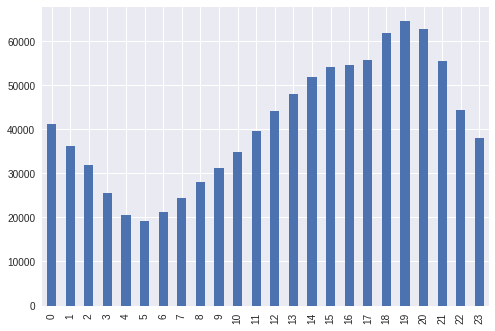

In [10]:
df['hour_of_day'].value_counts().sort_index().plot(kind='bar')

The above bar graph shows that people least visit the website around **2-10am** but peaks between **7-9pm** 

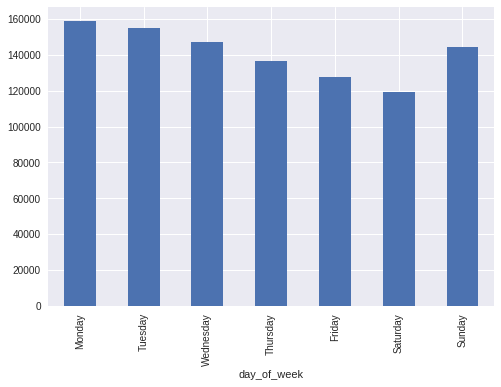

In [11]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(weekdays)}
key = df['day_of_week'].map(mapping)
df.iloc[key.argsort()].groupby('day_of_week', sort=False).size().plot(kind='bar')

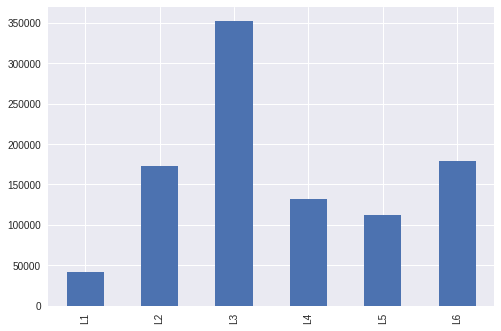

In [12]:
df['locale'].value_counts().sort_index().plot(kind='bar')

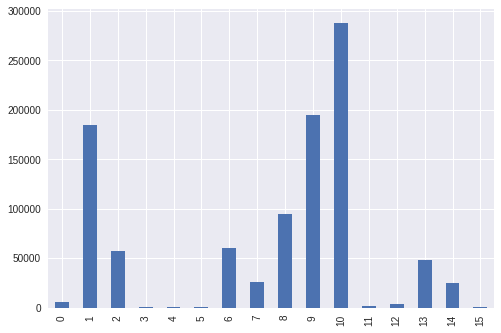

In [13]:
df['agent_id'].value_counts().sort_index().plot(kind='bar')

In [14]:
# Let's see the number of rows for Training and Testing dataframe
total_count = df['hits'].count()
missing = df['hits'].value_counts()['\N']
useful = total_count - missing

print "Total number of values in 'hits' column: %d (%d%%)" % (total_count, (total_count/ total_count) * 100)
print "Training Values:                         %d (%.2f%%)" % (useful, (useful/float(total_count))*100)
print "Testing Values:                          %d (%.2f%%)" % (missing, (missing/float(total_count))*100)

Total number of values in 'hits' column: 988681 (100%)
Training Values:                         619235 (62.63%)
Testing Values:                          369446 (37.37%)


In [15]:
# Create a new column which represent if row is Trainable or not
dataset = df.copy()
dataset['is_train'] = dataset['hits'] != '\\N'

In [16]:
# Replace \N to np.nan so that modules can handle these values
dataset = dataset.replace('\\N', np.nan)

In [17]:
# Counting how many nan values are there in the dataset in each columns
dataset.isnull().sum()

row_num                   0
locale                    0
day_of_week               0
hour_of_day               0
agent_id                  0
entry_page                0
path_id_set            4889
traffic_type              0
session_durantion       668
hits                 369446
is_train                  0
dtype: int64

In [18]:
# Generating a new column based on session_duration and path_id_set column, this
# extra information can help our trees divide the dataset better and learn better

dataset['session_isnull'] = dataset['session_durantion'] == np.nan
dataset['path_isnull'] = dataset['path_id_set'] == np.nan

In [19]:
# In the top **info()** function we saw that our few columns such as 
# session_duration or hits are not int type so let's convert them

dataset['session_durantion'] = dataset['session_durantion'].apply(pd.to_numeric, errors='coerce')
dataset['hits'] = dataset['hits'].apply(pd.to_numeric, errors='coerce')

In [20]:
# Let's replace nan values with some arbitary big negative 
# value which will be handled by our tree models

cols = list(set(dataset.columns) - set(['hits']))
dataset[cols] = dataset[cols].fillna(-999)

In [21]:
# Converting locale and traffic type column to frequency encoding
# useful than other encoding methods such as LabelEncoding as
# it keeps the information such as the frequency a particular category
# is present in the dataset

freq_encoding = dataset.groupby('locale').size()
freq_encoding = freq_encoding / len(dataset)
dataset['locale_enc'] = dataset.locale.map(freq_encoding)

freq_encoding = dataset.groupby('traffic_type').size()
freq_encoding = freq_encoding / len(dataset)
dataset['traffic_enc'] = dataset.traffic_type.map(freq_encoding)

In [22]:
# Normaly some time, day of the week or particular hour is not useful because
# time is a continues cyclic feature which is hard to represent just in some 
# numbers or LabelEncoder. I used sin and cos function to represent the time 
# and week of the day in a cyclic and repetitive manner. This code first encodes
# weekdays and time as Mon 00:00 as 0.0 and Sun 23:59 as 0.9999 then using
# sin and cos function to convert that range from 0-1 to sin/ cos function range
# which makes it cyclic pattern.

label_dict = {'Monday': float(0)/7, 'Tuesday': float(1)/7, 'Wednesday': float(2)/7, 'Thursday': float(3)/7,
              'Friday': float(4)/7, 'Saturday': float(5)/7, 'Sunday': float(6)/7}

dataset['week_enc'] = dataset['day_of_week']
for day in dataset['day_of_week'].unique():
    dataset['week_enc'] = dataset['week_enc'].replace(day, label_dict[day])

hours_in_day = 24
dataset['combined_sin'] = np.sin(dataset.week_enc*(dataset.hour_of_day*(2.*np.pi/hours_in_day)))
dataset['combined_cos'] = np.cos(dataset.week_enc*(dataset.hour_of_day*(2.*np.pi/hours_in_day)))

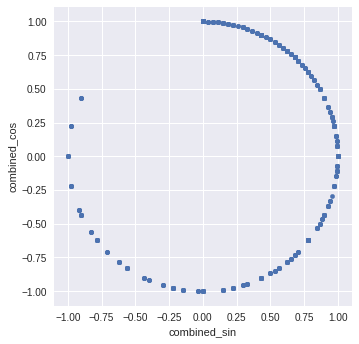

In [23]:
# This graph shows the cyclic nature of day of the week and hour of the day
dataset.sample(1000).plot.scatter('combined_sin', 'combined_cos').set_aspect('equal')

In [24]:
# Counted total number of pages visit in a session and made a new feature
# count_pages which is more useful than encoding paths in some way.

dataset.loc[::, 'count_page'] = dataset.loc[::, 'path_id_set'].apply(lambda x: len(x.split(';')) if isinstance(x, basestring) else 0)

In [25]:
# Generating a new feature using entry page and session duration by multiplying
# This will give our model easy to find some pattern between 2 feature relation
# Entry page and Session Duration

entry_session = dataset['entry_page'] * dataset['session_durantion']
dataset.insert(loc=1, column='entry_session', value=entry_session)

In [27]:
# Distributing dataset between training and testing (submit)

train = dataset[~np.isnan(dataset['hits'])]
test = dataset[np.isnan(dataset['hits'])]

In [28]:
# Dropping non numeric columns which are not being used for training purposes

X = train.drop(['hits', 'day_of_week', 'locale', 'path_id_set', 'is_train'], axis=1)
y = pd.DataFrame(train['hits'])

In [29]:
# Shuffling and splitting dataset for validation while training the model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [30]:
# Coverting the dataset to matrix form for XGBoost Model

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Some default params

params = {
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.01,
    'subsample': 1,
    'colsample_bytree': 1,
    'silent': 1,
    'objective':'gpu:reg:linear',
}

params['eval_metric'] = "rmse"
num_boost_round = 9999

In [ ]:
# Searching different values and best values for multiple params

#################### MAX DEPTH and MIN CHILD WEIGHT##########################
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(3, 12)
    for min_child_weight in range(1, 8)
]

min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=20
    )

    # Update best rmse
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)

print("Best params: {}, {}, rmse: {}".format(best_params[0], best_params[1], min_rmse))
params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]


######################SUB SAMPLE AND COLS SAMPLE#######################################

gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

min_rmse = float("Inf")
best_params = None

for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))

    params['subsample'] = subsample
    params['colsample_bytree'] = colsample

    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=50
    )

    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)

print("Best params: {}, {}, rmse: {}".format(best_params[0], best_params[1], min_rmse))
params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[0]


In [48]:
print("Our best params: {}".format(params)) 

# Let's train our model with best params that we searched
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=20
)

# Saving the model for re-producing the same results
print("Best RMSE: {:.2f} in {} rounds".format(best_model.best_score, best_model.best_iteration+1))
best_model.save_model("xgb_model.model")

Our best params: {'colsample_bytree': 1, 'silent': 1, 'eval_metric': 'rmse', 'min_child_weight': 1, 'subsample': 1, 'eta': 0.01, 'objective': 'gpu:reg:linear', 'max_depth': 6}
[0]	Test-rmse:42.5804
Will train until Test-rmse hasn't improved in 20 rounds.
[1]	Test-rmse:42.3948
[2]	Test-rmse:42.2122
[3]	Test-rmse:42.0315
[4]	Test-rmse:41.8545
[5]	Test-rmse:41.6792
[6]	Test-rmse:41.5077
[7]	Test-rmse:41.3387
[8]	Test-rmse:41.1728
[9]	Test-rmse:41.0093
[10]	Test-rmse:40.8484
[11]	Test-rmse:40.6893
[12]	Test-rmse:40.5332
[13]	Test-rmse:40.3798
[14]	Test-rmse:40.229
[15]	Test-rmse:40.0803
[16]	Test-rmse:39.9335
[17]	Test-rmse:39.7901
[18]	Test-rmse:39.6477
[19]	Test-rmse:39.5086
[20]	Test-rmse:39.3705
[21]	Test-rmse:39.2355
[22]	Test-rmse:39.1033
[23]	Test-rmse:38.9734
[24]	Test-rmse:38.8449
[25]	Test-rmse:38.7185
[26]	Test-rmse:38.594
[27]	Test-rmse:38.4713
[28]	Test-rmse:38.3511
[29]	Test-rmse:38.2319
[30]	Test-rmse:38.1154
[31]	Test-rmse:38.0006
[32]	Test-rmse:37.8877
[33]	Test-rmse:37.77

[338]	Test-rmse:31.4818
[339]	Test-rmse:31.4813
[340]	Test-rmse:31.4806
[341]	Test-rmse:31.4798
[342]	Test-rmse:31.4794
[343]	Test-rmse:31.4784
[344]	Test-rmse:31.478
[345]	Test-rmse:31.477
[346]	Test-rmse:31.4766
[347]	Test-rmse:31.4758
[348]	Test-rmse:31.4754
[349]	Test-rmse:31.475
[350]	Test-rmse:31.4746
[351]	Test-rmse:31.4744
[352]	Test-rmse:31.4735
[353]	Test-rmse:31.4733
[354]	Test-rmse:31.473
[355]	Test-rmse:31.4724
[356]	Test-rmse:31.4719
[357]	Test-rmse:31.4715
[358]	Test-rmse:31.471
[359]	Test-rmse:31.4707
[360]	Test-rmse:31.4695
[361]	Test-rmse:31.4692
[362]	Test-rmse:31.468
[363]	Test-rmse:31.4678
[364]	Test-rmse:31.4673
[365]	Test-rmse:31.4672
[366]	Test-rmse:31.467
[367]	Test-rmse:31.4672
[368]	Test-rmse:31.4672
[369]	Test-rmse:31.467
[370]	Test-rmse:31.4672
[371]	Test-rmse:31.467
[372]	Test-rmse:31.4669
[373]	Test-rmse:31.4672
[374]	Test-rmse:31.467
[375]	Test-rmse:31.4666
[376]	Test-rmse:31.4665
[377]	Test-rmse:31.4668
[378]	Test-rmse:31.4665
[379]	Test-rmse:31.4666
[3

In [34]:
# Feature importance sorted by the usefullness of individual features
sorted(best_model.get_fscore().items(), key=lambda kv: kv[1], reverse=True)

[('count_page', 4493),
 ('entry_session', 4418),
 ('entry_page', 4250),
 ('session_durantion', 2733),
 ('agent_id', 2561),
 ('traffic_type', 2070),
 ('row_num', 1281),
 ('hour_of_day', 756),
 ('locale_enc', 628),
 ('combined_sin', 459),
 ('week_enc', 338),
 ('combined_cos', 330),
 ('traffic_enc', 239)]

In [47]:
# Converting the dataset to predict the hits and save it in csv file
X_submit = test.drop(['hits', 'day_of_week', 'locale', 'path_id_set', 'is_train'], axis=1)
dsubmit = xgb.DMatrix(X_submit)

submit_pred = best_model.predict(dsubmit)

csv_df = pd.DataFrame({'row_num': test['row_num'], 'hits': submit_pred}, columns=['row_num', 'hits'])
csv_df.to_csv('submit.csv', index=False)